## We now have clean, good ride requests data.
### Cluster of Latitude-Longitude is done, we have around 50 pickup_clusters.
### We have grouped ride request day in 30mins interval. 

### Total Data Rows: 366days * 48 intervals * 50 clusters = 878400

### `AIM: To forecast demand for a given latitude-longitude`

### `Metric: RMSE, how close we are able to predict ride demand to true value`

Author: [Shaurya Uppal](https://www.linkedin.com/in/shaurya-uppal/)

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt, ceil, floor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from joblib import dump, load
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/Data_Prepared.csv', compression = 'gzip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ts              878400 non-null  object 
 1   pickup_cluster  878400 non-null  int64  
 2   request_count   878400 non-null  float64
 3   mins            878400 non-null  int64  
 4   hour            878400 non-null  int64  
 5   day             878400 non-null  int64  
 6   month           878400 non-null  int64  
 7   dayofweek       878400 non-null  int64  
 8   quarter         878400 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 60.3+ MB


In [4]:
df['request_count'] = pd.to_numeric(df['request_count'], downcast = 'integer')
df.ts = pd.to_datetime(df.ts)
df.head(10)

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
0,2020-03-26 00:00:00,0,0,0,0,26,3,3,1
1,2020-03-26 00:30:00,0,0,30,0,26,3,3,1
2,2020-03-26 01:00:00,0,0,0,1,26,3,3,1
3,2020-03-26 01:30:00,0,0,30,1,26,3,3,1
4,2020-03-26 02:00:00,0,0,0,2,26,3,3,1
5,2020-03-26 02:30:00,0,0,30,2,26,3,3,1
6,2020-03-26 03:00:00,0,0,0,3,26,3,3,1
7,2020-03-26 03:30:00,0,0,30,3,26,3,3,1
8,2020-03-26 04:00:00,0,0,0,4,26,3,3,1
9,2020-03-26 04:30:00,0,0,30,4,26,3,3,1


In [5]:
df = df[['ts','pickup_cluster','mins','hour','month','quarter','dayofweek','request_count']]

In [6]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0
3,2020-03-26 01:30:00,0,30,1,3,1,3,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0
...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,2
878396,2021-03-26 22:00:00,49,0,22,3,1,4,2
878397,2021-03-26 22:30:00,49,30,22,3,1,4,6
878398,2021-03-26 23:00:00,49,0,23,3,1,4,0


In [7]:
# First 24days of every month in Train and last 7 days of everymonth in Test
df_train = df[df.ts.dt.day <=23]
df_test = df[df.ts.dt.day >23]

In [8]:
len(df_train)

662400

In [9]:
len(df_test)

216000

In [18]:
X = df_train.iloc[:,1:-1]
X

,pickup_cluster,mins,hour,month,quarter,dayofweek
288,0,0,0,4,2,2
289,0,30,0,4,2,2
290,0,0,1,4,2,2
291,0,30,1,4,2,2
292,0,0,2,4,2,2
...,...,...,...,...,...,...
878251,49,30,21,3,1,1
878252,49,0,22,3,1,1
878253,49,30,22,3,1,1
878254,49,0,23,3,1,1


In [10]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

In [11]:
def metrics_calculate(regressor):
    y_pred = regressor.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    return rms

# Iteration: 1
Features: ['pickup_cluster','mins','hour','month','quarter','dayofweek']

In [12]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 6.357143528895981, RMSE TEST:6.289366827316201


### High Bais | Underfit
#### It is used to determine the extent to which there is a linear relationship between a dependent variable and one or more independent variables.
#### Moving to Ensemble Regressors: Bagging Algorithm Random Forest 
#### Random Forest Regressor: Random forests are bagged decision tree models that split on a subset of features on each split.
#### Give Feature importance based on target variable

In [13]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state=42, n_jobs = -1, verbose=True)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   41.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    7.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.7s


RMSE TRAIN: 1.8990044939607205, RMSE TEST:4.121561955699205


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    4.0s finished


In [14]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
pickup_cluster,0.348275
hour,0.292656
month,0.154055
quarter,0.100247
dayofweek,0.086621
mins,0.018146


### Random Forest Tend to Overfit

### Moving to a Ensemble: Boosting Algorithm
+ Here: learners are learned sequentially

In [21]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1000, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set)
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:6.47642
[1]	validation_0-rmse:6.44626
[2]	validation_0-rmse:6.41696
[3]	validation_0-rmse:6.38818
[4]	validation_0-rmse:6.35955
[5]	validation_0-rmse:6.33150
[6]	validation_0-rmse:6.30350
[7]	validation_0-rmse:6.27644
[8]	validation_0-rmse:6.25000
[9]	validation_0-rmse:6.22431
[10]	validation_0-rmse:6.19818
[11]	validation_0-rmse:6.17352
[12]	validation_0-rmse:6.14926
[13]	validation_0-rmse:6.12434
[14]	validation_0-rmse:6.10091
[15]	validation_0-rmse:6.07685
[16]	validation_0-rmse:6.05403
[17]	validation_0-rmse:6.03095
[18]	validation_0-rmse:6.00790
[19]	validation_0-rmse:5.98571
[20]	validation_0-rmse:5.96446
[21]	validation_0-rmse:5.94311
[22]	validation_0-rmse:5.92154
[23]	validation_0-rmse:5.90060
[24]	validation_0-rmse:5.88059
[25]	validation_0-rmse:5.86036
[26]	validation_0-rmse:5.84062
[27]	validation_0-rmse:5.82073
[28]	validation_0-rmse:5.80134
[29]	validation_0-rmse:5.78276
[30]	validation_0-rmse:5.76285
[31]	validation_0-rmse:5.74555
[32]	validation_0-

In [23]:
dump(model,'../data/prediction_model_without_lag.joblib',compress=3)

['../data/prediction_model_without_lag.joblib']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

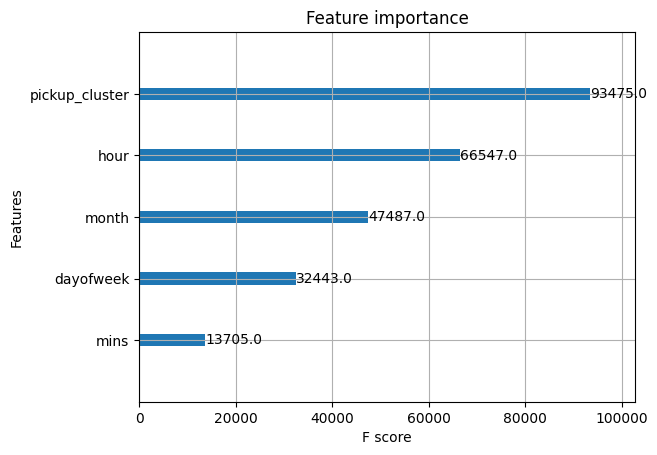

In [24]:
# plot feature importance
plot_importance(model)


# Iteration 2
Features: ['pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']

## Include: Lag Features

### If there is 30mins trend, how has ride requests been in last 1.5 hours. 
+ Hence testing with Lag Shift by 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.

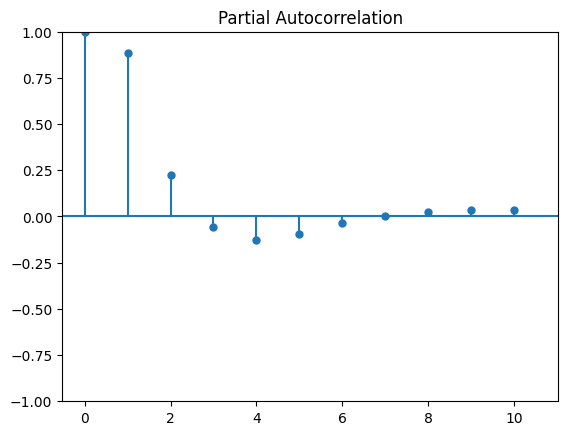

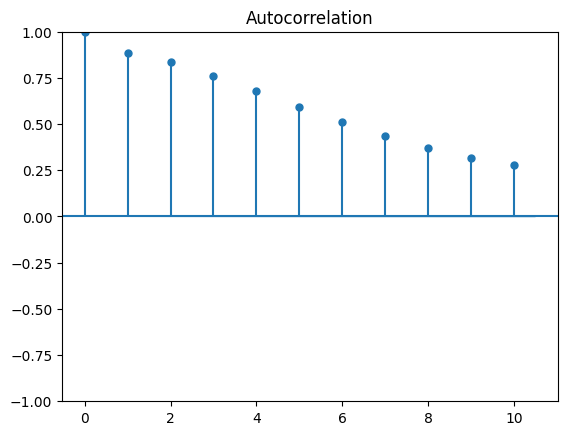

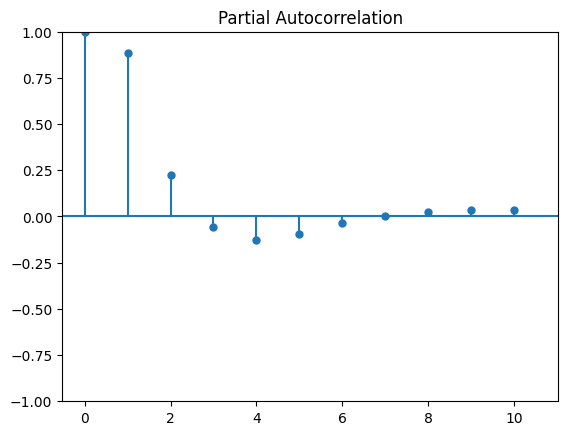

In [25]:
plot_acf(df_train['request_count'], lags=10)
plot_pacf(df_train['request_count'], lags=10)

The partial autocorrelation function shows a high correlation with the first two lag and lesser correlation with the 3rd and 4th lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

+ ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
+ PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

In [26]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp.head(15)

,,,,,,,request_count,lag_1,lag_2,lag_3
ts,pickup_cluster,mins,hour,month,quarter,dayofweek,,,,
2020-03-26 00:00:00,0,0,0,3,1,3,0,NaN,NaN,NaN
2020-03-26 00:30:00,0,30,0,3,1,3,0,0.0,NaN,NaN
2020-03-26 01:00:00,0,0,1,3,1,3,0,0.0,0.0,NaN
2020-03-26 01:30:00,0,30,1,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:00:00,0,0,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:30:00,0,30,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:00:00,0,0,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:30:00,0,30,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 04:00:00,0,0,4,3,1,3,0,0.0,0.0,0.0


In [27]:
temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3',
        'request_count']]

In [28]:
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

In [29]:
X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [30]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 0.9575364302196911, RMSE TEST:2.5532154420346553


### Random Fores - Overfits || Moving to Boosting Algorithm

In [31]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
lag_1,0.791373
hour,0.046313
pickup_cluster,0.041379
lag_2,0.038768
lag_3,0.030041
dayofweek,0.020786
month,0.018669
mins,0.007961
quarter,0.004709


In [32]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=600, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=30,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

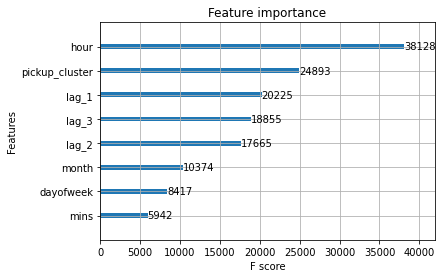

In [ ]:
plot_importance(model)

### Xgboost perform better than random forest

<hr>

# Iteration3:
Features: ['pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean']
## Include: Both Lag Features and Rolling Window
+ Both of size = 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.
<br>
rolling_mean: previous 3 days request_count mean

In [ ]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp['rolling_mean'] = temp.groupby(level=['pickup_cluster'])['request_count'].apply(lambda x: x.rolling(window = 3).mean()).shift(1)

temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean','request_count']]
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
# regressor.fit(X,y)
# print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

# feature_importances = pd.DataFrame(regressor.feature_importances_,
#                                    index = X.columns,
#                                     columns=['importance']).sort_values('importance',ascending=False)
# feature_importances

In [ ]:
# dump(regressor, 'random_forest.joblib')

## Random Forest Overfits i.e. performs good on training dataset and bad on test dataset

In [ ]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1500, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=20,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:8.28999
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:8.21758
[2]	validation_0-rmse:8.14566
[3]	validation_0-rmse:8.07464
[4]	validation_0-rmse:8.00427
[5]	validation_0-rmse:7.93453
[6]	validation_0-rmse:7.86569
[7]	validation_0-rmse:7.7972
[8]	validation_0-rmse:7.73024
[9]	validation_0-rmse:7.66368
[10]	validation_0-rmse:7.59799
[11]	validation_0-rmse:7.53296
[12]	validation_0-rmse:7.46855
[13]	validation_0-rmse:7.405
[14]	validation_0-rmse:7.34186
[15]	validation_0-rmse:7.27974
[16]	validation_0-rmse:7.21814
[17]	validation_0-rmse:7.15751
[18]	validation_0-rmse:7.09775
[19]	validation_0-rmse:7.03806
[20]	validation_0-rmse:6.97938
[21]	validation_0-rmse:6.92144
[22]	validation_0-rmse:6.86403
[23]	validation_0-rmse:6.80739
[24]	validation_0-rmse:6.75107
[25]	validation_0-rmse:6.69561
[26]	validation_0-rmse:6.64078
[27]	validation_0-rmse:6.58602
[28]	validation_0-rmse:6.53247
[29]	validation_0-rmse:6.47962
[30]	validation_0-

[259]	validation_0-rmse:2.68354
[260]	validation_0-rmse:2.68168
[261]	validation_0-rmse:2.67977
[262]	validation_0-rmse:2.67799
[263]	validation_0-rmse:2.67623
[264]	validation_0-rmse:2.67447
[265]	validation_0-rmse:2.6727
[266]	validation_0-rmse:2.67101
[267]	validation_0-rmse:2.66934
[268]	validation_0-rmse:2.66752
[269]	validation_0-rmse:2.66584
[270]	validation_0-rmse:2.66426
[271]	validation_0-rmse:2.66268
[272]	validation_0-rmse:2.66113
[273]	validation_0-rmse:2.65964
[274]	validation_0-rmse:2.65806
[275]	validation_0-rmse:2.65647
[276]	validation_0-rmse:2.65498
[277]	validation_0-rmse:2.65356
[278]	validation_0-rmse:2.65214
[279]	validation_0-rmse:2.65079
[280]	validation_0-rmse:2.6495
[281]	validation_0-rmse:2.6481
[282]	validation_0-rmse:2.64682
[283]	validation_0-rmse:2.64546
[284]	validation_0-rmse:2.64421
[285]	validation_0-rmse:2.64296
[286]	validation_0-rmse:2.64171
[287]	validation_0-rmse:2.64051
[288]	validation_0-rmse:2.63927
[289]	validation_0-rmse:2.63811
[290]	valid

[516]	validation_0-rmse:2.52621
[517]	validation_0-rmse:2.52586
[518]	validation_0-rmse:2.52577
[519]	validation_0-rmse:2.52563
[520]	validation_0-rmse:2.52559
[521]	validation_0-rmse:2.52537
[522]	validation_0-rmse:2.52529
[523]	validation_0-rmse:2.52503
[524]	validation_0-rmse:2.5248
[525]	validation_0-rmse:2.5245
[526]	validation_0-rmse:2.52419
[527]	validation_0-rmse:2.52409
[528]	validation_0-rmse:2.52405
[529]	validation_0-rmse:2.52391
[530]	validation_0-rmse:2.52383
[531]	validation_0-rmse:2.52361
[532]	validation_0-rmse:2.52342
[533]	validation_0-rmse:2.52324
[534]	validation_0-rmse:2.52314
[535]	validation_0-rmse:2.52287
[536]	validation_0-rmse:2.52266
[537]	validation_0-rmse:2.52253
[538]	validation_0-rmse:2.52231
[539]	validation_0-rmse:2.52211
[540]	validation_0-rmse:2.52197
[541]	validation_0-rmse:2.52191
[542]	validation_0-rmse:2.5218
[543]	validation_0-rmse:2.52167
[544]	validation_0-rmse:2.52155
[545]	validation_0-rmse:2.52144
[546]	validation_0-rmse:2.52133
[547]	valid

[773]	validation_0-rmse:2.48766
[774]	validation_0-rmse:2.48756
[775]	validation_0-rmse:2.48744
[776]	validation_0-rmse:2.48731
[777]	validation_0-rmse:2.48713
[778]	validation_0-rmse:2.48697
[779]	validation_0-rmse:2.48686
[780]	validation_0-rmse:2.48684
[781]	validation_0-rmse:2.48676
[782]	validation_0-rmse:2.48665
[783]	validation_0-rmse:2.48652
[784]	validation_0-rmse:2.48634
[785]	validation_0-rmse:2.4862
[786]	validation_0-rmse:2.48611
[787]	validation_0-rmse:2.48597
[788]	validation_0-rmse:2.48587
[789]	validation_0-rmse:2.48575
[790]	validation_0-rmse:2.48571
[791]	validation_0-rmse:2.48564
[792]	validation_0-rmse:2.48554
[793]	validation_0-rmse:2.48537
[794]	validation_0-rmse:2.48528
[795]	validation_0-rmse:2.48509
[796]	validation_0-rmse:2.48499
[797]	validation_0-rmse:2.48481
[798]	validation_0-rmse:2.48468
[799]	validation_0-rmse:2.48454
[800]	validation_0-rmse:2.48444
[801]	validation_0-rmse:2.48433
[802]	validation_0-rmse:2.48425
[803]	validation_0-rmse:2.48408
[804]	val

[1029]	validation_0-rmse:2.46807
[1030]	validation_0-rmse:2.46802
[1031]	validation_0-rmse:2.46805
[1032]	validation_0-rmse:2.46798
[1033]	validation_0-rmse:2.46805
[1034]	validation_0-rmse:2.46787
[1035]	validation_0-rmse:2.46782
[1036]	validation_0-rmse:2.46769
[1037]	validation_0-rmse:2.46769
[1038]	validation_0-rmse:2.46761
[1039]	validation_0-rmse:2.46755
[1040]	validation_0-rmse:2.46738
[1041]	validation_0-rmse:2.46728
[1042]	validation_0-rmse:2.46719
[1043]	validation_0-rmse:2.46719
[1044]	validation_0-rmse:2.46721
[1045]	validation_0-rmse:2.46719
[1046]	validation_0-rmse:2.46712
[1047]	validation_0-rmse:2.467
[1048]	validation_0-rmse:2.46692
[1049]	validation_0-rmse:2.46695
[1050]	validation_0-rmse:2.46693
[1051]	validation_0-rmse:2.46695
[1052]	validation_0-rmse:2.46687
[1053]	validation_0-rmse:2.46681
[1054]	validation_0-rmse:2.46673
[1055]	validation_0-rmse:2.46656
[1056]	validation_0-rmse:2.46644
[1057]	validation_0-rmse:2.4664
[1058]	validation_0-rmse:2.46622
[1059]	valida

[1279]	validation_0-rmse:2.45769
[1280]	validation_0-rmse:2.45768
[1281]	validation_0-rmse:2.45766
[1282]	validation_0-rmse:2.45761
[1283]	validation_0-rmse:2.45745
[1284]	validation_0-rmse:2.45745
[1285]	validation_0-rmse:2.45746
[1286]	validation_0-rmse:2.45748
[1287]	validation_0-rmse:2.45745
[1288]	validation_0-rmse:2.45734
[1289]	validation_0-rmse:2.45739
[1290]	validation_0-rmse:2.45732
[1291]	validation_0-rmse:2.45727
[1292]	validation_0-rmse:2.45726
[1293]	validation_0-rmse:2.45721
[1294]	validation_0-rmse:2.45718
[1295]	validation_0-rmse:2.45709
[1296]	validation_0-rmse:2.4571
[1297]	validation_0-rmse:2.45709
[1298]	validation_0-rmse:2.45707
[1299]	validation_0-rmse:2.45709
[1300]	validation_0-rmse:2.45707
[1301]	validation_0-rmse:2.45704
[1302]	validation_0-rmse:2.45704
[1303]	validation_0-rmse:2.45697
[1304]	validation_0-rmse:2.45693
[1305]	validation_0-rmse:2.45698
[1306]	validation_0-rmse:2.45694
[1307]	validation_0-rmse:2.45695
[1308]	validation_0-rmse:2.4569
[1309]	valid

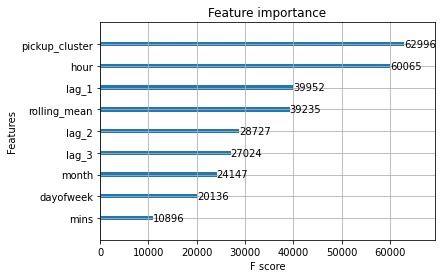

In [ ]:
plot_importance(model)

In [ ]:
dump(model,'../Model/prediction_model.joblib',compress=3)

['../Model/prediction_model.joblib']

### Comment: Lag Features and Rolling Mean has improved RMSE

<hr>

# Final Model: Iteration3
+ Good performance with feature addition

# Has Features: `['pickup_cluster','mins','hour','month','dayofweek','quarter', 'lag_1','lag_2','lag_3','rolling_mean']`

### Model Score: 0.91

In [ ]:
model = load('../Model/prediction_model.joblib')

In [ ]:
model.predict(X_test)

array([ 0.21119007,  0.22959417,  0.22166237, ..., 10.994667  ,
        9.126653  ,  7.051732  ], dtype=float32)